In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

yolosac = pd.read_csv('yolosac3.csv')
# yolosac3 has multiple listings of the same business
yolosac.drop_duplicates(subset=['gmap_id'], inplace=True)
#yolosac.set_index('gmap_id', inplace=True)
yolosac.drop(yolosac.columns[0], axis=1, inplace=True)


In [2]:
categories = print(yolosac['category'].explode().value_counts())

category
restaurant    3559
auto          2070
retail        1762
beauty        1281
recreation    1210
health         745
grocery        450
education      353
Name: count, dtype: int64


### THIS CODE BLOCK WORKS (I think)

Takes 230 minutes to run.
Possible optimizations:
- Load reviews into DataFrame
- Groupby `gmap_id`
- If `gmap_id` is not in `yolosac`, remove group

In [78]:
# Open the file and load the JSON array
with open('data/yolosac-reviews.json', 'r') as file:
    data = json.load(file)

remove = False
prev_id = ''
category = ''
# Reviews in file are ordered by business already. This should speed up category assignment.
for review in reversed(data):
    # if review has different id than previous
    if review['gmap_id'] != prev_id:
        prev_id = review['gmap_id']   
        try:
            # try to lookup category
            category = yolosac[yolosac['gmap_id'] == review['gmap_id']]['category'].iloc[0]
            review['category'] = category
            remove = False
        except IndexError:
            data.remove(review)
            remove = True
    else:
        if remove:
            data.remove(review)
        else:
            review['category'] = category

print(len(data))
with open('data/ys-reviews-with-categories.json', 'w') as file:
    json.dump(data, file)
    file.close()

1275985


In [4]:
import zipfile

# Specify the file paths
source_file = 'data/ys-reviews-with-categories.json'
zip_file = 'ys-reviews-with-categories.zip'

# Create a Zip file and add the source file to it
with zipfile.ZipFile(zip_file, 'w',zipfile.ZIP_DEFLATED, compresslevel=9) as zipf:
    zipf.write(source_file)


# EDA

Our model will use the reviews dataset from `ys-reviews-with-categories.zip` to predict a business's success score. Success depends on number of reviews and the rating score.
All the variables we will use are categorical. We intend to extract vectors with the most relevant words from each review.

In [5]:
yolosac.head()

,name,gmap_id,category,avg_rating,num_of_reviews
0,Aurora Massage,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty,4.2,56
1,Orient Massage,0x809adee9ac6f1bd7:0xe2e56d16919b9b8d,beauty,3.6,15
2,Valley Gaming & Billiards Home,0x809add6b2d273da5:0x4610dea4cb4aa5df,retail,4.1,18
3,Dan's Mission Towing,0x809ad4111dd01501:0xf8adf3a057108e2a,auto,3.3,6
4,Caballo Bronco Barber Styling,0x809ad73dbbfe5ef1:0x45f57e4e50d4c232,beauty,4.0,28


In [2]:
with open('data/ys-reviews-with-categories.json', 'r') as file:
    data = json.load(file)

reviews = pd.DataFrame(data)
reviews.head()

,text,rating,gmap_id,category
0,Helped me alot. If it was for her suggesting m...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
1,Always leave feeling refreshed...polite and re...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
2,Professional massage place. The ladies know w...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
3,This place was pleasing to me. Very nice staff...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
4,Tough lady loves great pressure massage. Woohoo.,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty


In [13]:
reviews_by_business = reviews.groupby('category', axis=0)

Text(0.5, 1.0, 'Frequency of businesses for each category')

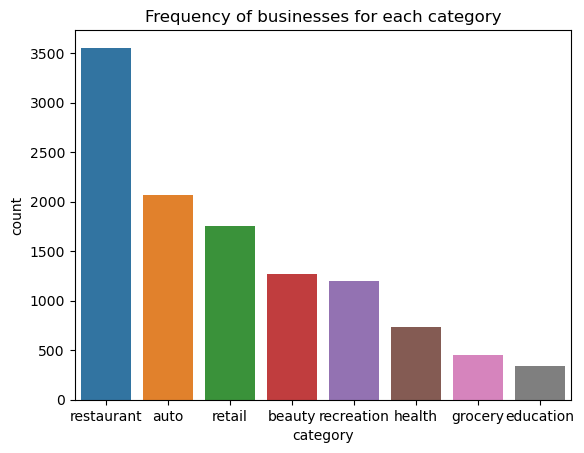

In [3]:
sns.countplot(data=yolosac, x='category', order=yolosac['category'].value_counts().index)
plt.title('Frequency of businesses for each category')

Text(0.5, 1.0, 'Frequency of reviews for business categories')

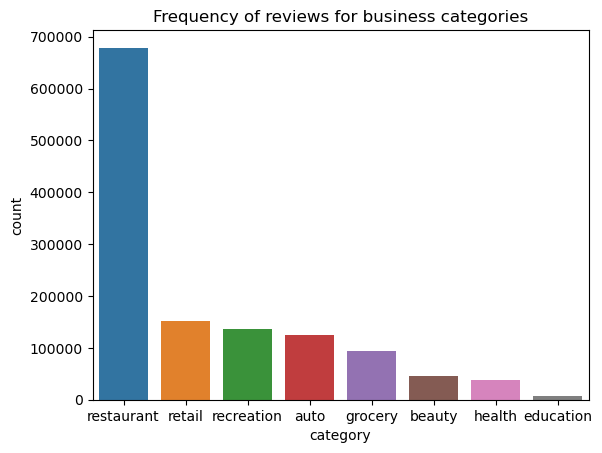

In [4]:
sns.countplot(data=reviews, x='category', order=reviews['category'].value_counts().index)
plt.title('Frequency of reviews for business categories')

Observations:
- About half of all reviews are from restaurants

In [9]:
review_freq_norm = reviews['category'].value_counts() / yolosac['category'].value_counts()
print(review_freq_norm.sort_values(ascending=False))

category
grocery       208.944321
restaurant    190.984524
recreation    114.218984
retail         85.940239
auto           60.371609
health         51.240163
beauty         36.284136
education      19.979710
Name: count, dtype: float64


Observations:
- Grocery businesses get the most reviews on average
- Restaurants get the second most reviews on average
- Educational institutions get the least reviews on average

Questions:
- Grocery business includes big-box stores like Walmart and Target. Do these chains contribute to over-inflated review counts?

Question: What is the distribution of businesses with 1-2, 2-3, 3-4, 4-5 star ratings? Does it vary across business categories?

<Axes: xlabel='avg_rating', ylabel='Count'>

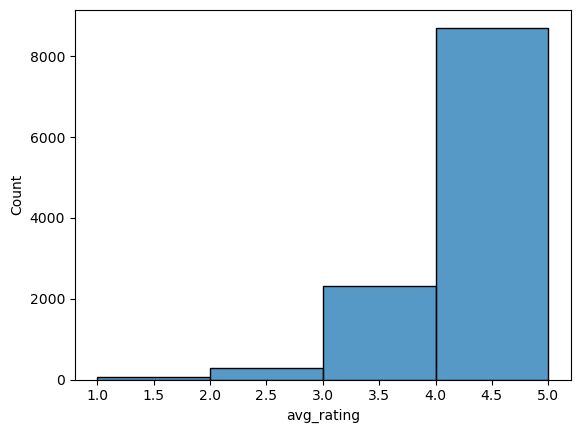

In [11]:
sns.histplot(data=yolosac, x='avg_rating', bins=4)

Observations:
- Business ratings are highly skewed left

Question:
- Do we need to reduce the number of highy rated businesses in training data?
- What is the cutoff for being a successful business?

In [20]:
# business count for each rating bucket (1-2, 2-3, 3-4, 4-5)
# Lower limit of 0.9 accounts for businesses with 1-star rating
print(pd.cut(yolosac['avg_rating'], [0.9, 2, 3, 4 ,5]).value_counts())

# 4-5 star businesses vs. all other businesses
print(pd.cut(yolosac['avg_rating'], [0.9, 4 ,5]).value_counts())


avg_rating
(4.0, 5.0]    8025
(3.0, 4.0]    2903
(2.0, 3.0]     372
(0.9, 2.0]      74
Name: count, dtype: int64
avg_rating
(4.0, 5.0]    8025
(0.9, 4.0]    3349
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of 4-5 star businesses')

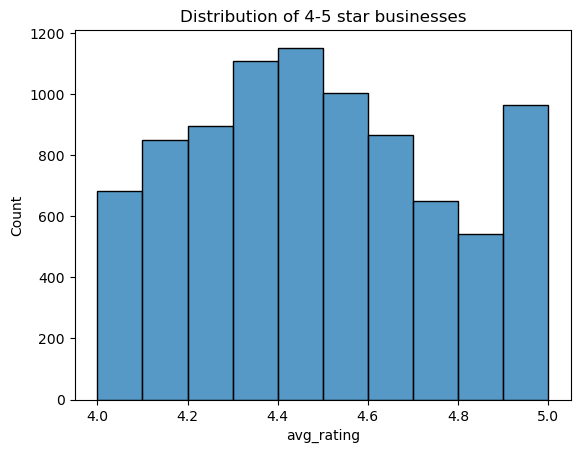

In [35]:
sns.histplot(data=yolosac[(yolosac['avg_rating'] >= 4)], x='avg_rating', bins=10)
plt.title('Distribution of 4-5 star businesses')

4-5 star businesses are roughly normally distributed, except at the right end. This is probably because the last bin includes 5-star businesses that may only have a few reviews.

In [36]:
split_on_ratings = pd.cut(yolosac['avg_rating'], [0.9, 2, 3, 4 ,5])
split_on_ratings.head

<class 'pandas.core.series.Series'>
Index: 11374 entries, 0 to 11429
Series name: avg_rating
Non-Null Count  Dtype   
--------------  -----   
11374 non-null  category
dtypes: category(1)
memory usage: 100.2 KB
